<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.1/Binary_Classification(%2Bscaler).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification

- Sigmoid 함수를 사용하는 Logistic Regression 방법으로 Classification하는 모델 만들기
- Features : 12 (생존 여부, 성별 등)
- Samples : 891
- Titanic Data로 생존(S), 사망(C) 판단하는 모델 만들기

In [60]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

[1] Data Processing

In [88]:
data_url = "/Titanic.csv"
df = pd.read_csv(data_url)
print (df.shape)
df
df.info() # NaN 값이 있는지 확인(나이와 cabin,Embarked 값이 다른 것으로 볼 때 없는 것 존재함 확인)

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [89]:

# 불필요한 항목 drop
df = df.drop(["Name", "Cabin", "Embarked","Ticket"], axis = 1)
# NaN값 있는 행 삭제
df = df.dropna()
# x값 에서 y값 항목 삭제
x = df.drop(["Survived"], axis = 1)
# 성별 숫자로 바꾸기
x["Sex"] = np.where(x["Sex"].to_numpy()=="male",0,1)
x
# y값 0과1로 변환
Surv = { "S": 1, "C": 0}
y = df["Survived"].replace(Surv)

print(x.shape)
print(y.shape)
y.head()

(714, 7)
(714,)


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [90]:
#학습데이터와 테스트데이터를 일정비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=85)
print("x_train의 크기:{}",x_train.shape)
print("y_train의 크기:{}",y_train.shape)
print("x_testn의 크기:{}",x_test.shape)
print("y_test의 크기:{}",y_test.shape)

x_train의 크기:{} (571, 7)
y_train의 크기:{} (571,)
x_testn의 크기:{} (143, 7)
y_test의 크기:{} (143,)


In [105]:
#학습 데이터 Scaling
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()
scaler.fit(x_train)
x_train_tran = scaler.transform(x_train)


#학습 데이터 배치화 시키기 
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train_tran),
                                 torch.FloatTensor(y_train.values))

dataloader = data_utils.DataLoader(train_data, batch_size=128, shuffle=False)


#배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape)
    print(datas[1].shape)
    break

#테스트 데이터 Scaling    
x_test_tran = scaler.transform(x_test)


#테스트 데이터 텐서로 변환
x_test_tensor = torch.FloatTensor(x_test_tran)
y_test_tensor = torch.FloatTensor(y_test.values)

0
torch.Size([128, 7])
torch.Size([128])


[2] Model

In [106]:
class LogisticRegression(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super(LogisticRegression, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            self.linear = torch.nn.Linear(self.input_size, self.output_size)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear(input_tensor)
            output = self.sigmoid(linear1)
            return output

In [109]:
#Hyper-parameter
input_size = 7
output_size = 1
learning_rate = 0.1
n_epochs = 500

#model 생성
model = LogisticRegression(input_size=input_size, output_size=output_size)

#손실함수 생성-BinaryCrossEntropyLoss 사용
criterion = torch.nn.BCELoss()  # 내부적으로 Softmax 함수가 적용됨
#Optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


[3] Training

In [110]:
# Accuracy(정확도) = 정답수 / 전체 예측 횟수
train_loss = []
test_loss = []
train_accuracy=[]
test_accuracy=[]

for epoch in range(n_epochs+1):
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)

        loss_train = criterion(y_pred.squeeze(), y_batch)
        
        #정답을 맞춘 예측값을 카운트
        #sigmoid 함수를 통과했기 때문에 0,1 사이의 값으로 반환됨
        
        prediction = [1 if x > 0.5 else 0 for x in y_pred.data.numpy()]
        correct = (prediction == y_batch.numpy()).sum()
        
        loss_train.backward()
        optimizer.step()
        
        #Validation
        model.eval()
        y_test_pred = model(x_test_tensor)
        loss_test = criterion(y_test_pred.squeeze(), y_test_tensor)
        prediction_test = [1 if x > 0.5 else 0 for x in y_test_pred.data.numpy()]
        correct_test = (prediction_test == y_test_tensor.data.numpy()).sum()


    
    accuracy_train = (100 * correct / len(prediction))
    accuracy_test = (100 * correct_test / len(prediction_test))
    
    train_loss.append(loss_train.data)
    test_loss.append(loss_test.data)
    train_accuracy.append(accuracy_train)
    test_accuracy.append(accuracy_test)    
    print(f'epoch:{epoch}, Loss_train:{train_loss[-1]:.2f}, Accuracy_train:{ train_accuracy[-1]:.2f}, Loss_test:{test_loss[-1]:.2f}, Accuracy_test:{test_accuracy[-1]:.2f}')
          

epoch:0, Loss_train:0.67, Accuracy_train:61.02, Loss_test:0.66, Accuracy_test:53.85
epoch:1, Loss_train:0.64, Accuracy_train:66.10, Loss_test:0.64, Accuracy_test:59.44
epoch:2, Loss_train:0.62, Accuracy_train:66.10, Loss_test:0.63, Accuracy_test:63.64
epoch:3, Loss_train:0.60, Accuracy_train:71.19, Loss_test:0.62, Accuracy_test:68.53
epoch:4, Loss_train:0.58, Accuracy_train:72.88, Loss_test:0.61, Accuracy_test:72.03
epoch:5, Loss_train:0.57, Accuracy_train:74.58, Loss_test:0.61, Accuracy_test:74.13
epoch:6, Loss_train:0.56, Accuracy_train:76.27, Loss_test:0.60, Accuracy_test:75.52
epoch:7, Loss_train:0.55, Accuracy_train:77.97, Loss_test:0.60, Accuracy_test:75.52
epoch:8, Loss_train:0.54, Accuracy_train:77.97, Loss_test:0.59, Accuracy_test:76.22
epoch:9, Loss_train:0.54, Accuracy_train:77.97, Loss_test:0.59, Accuracy_test:74.83
epoch:10, Loss_train:0.53, Accuracy_train:79.66, Loss_test:0.58, Accuracy_test:74.83
epoch:11, Loss_train:0.52, Accuracy_train:81.36, Loss_test:0.58, Accuracy_t

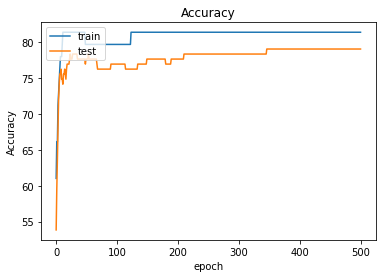

In [111]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()